In [1]:
# utility functions for accessing transfermarkt.com

from urllib2 import urlopen, Request
from bs4 import BeautifulSoup
from pandas import DataFrame
import pandas as pd
import numpy as np
import re
import os.path 
import datetime 

tier1=["GB1", "ES1", "IT1", "L1", "FR1", "TR1", "RU1", "PO1", "NL1", "BE1", "MLS1", 
            "UKR1", "GR1", "C1", "RO1", "KR1", "A1", "TS1", "DK1", "PL1", "SE1", "SER1", "NO1", "ISR1", "SC1", "BU1", "ZYP1"]
tier2=["GB2", "ES2", "IT2", "L2", "FR2", "TR2", "RU2", "PO2", "NL2", "BE2", "NAFC"]
tier3=["GB3", "L3", "IT3A", "IT3B", "IT3C"]
youthLeagues=["GB21", "AJ1", "AJ2", "AJ3", "ITJ1", "ITJ2", "ITJ3"]
otherEurope = ["KAS1", "BOS1", "UNG1", "WER1", "SL1", "SLO1", "GEO1", "AZ1", "ALB1", "MOL1", 
                           "FI1", "MAZ1", "MNE1", "LI1", "ARM1", "EST1", "LUX1", "LET1", "MAL1", "IS1", "IR1", "WAL1","NIR1", "FARO"]
world=["CSL", "JL11", "UAE1", "QSL", "RSK1", "IRN1", "SA1", "AUS1", "THA1", "NZL1", "HGKG", "LIB1", "IND1", "SIN1", "INIL", "PHI1",
             "EGY1", "SFA1", "ALG1", "TUN1", "MAR1", "GHPL"]
americas=["BRA1", "AR1N", "MEX1", "COLP", "ECPE", "CHL1", "URU1", "PERC", "PDV1", "VZ1A", "BRA2"]
defunct=["EFD2","ENSD","GBJG"]
deep=["RLW3","RLSW","RLN3","RLN4","RLB3","ES3A","ES3B","ES3C","ES3D","510","511",
            "TR3A","TR3B","TR4A","TR4B","TR4C", "GB4","CNAT", "NLAJ", "NLAE"]

# transfermarkt blocks default useragent
useragent = 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'
# "lol" can be anything - transfermarkt ignores it/uses it for semantic url
urlprefix = 'http://www.transfermarkt.com/lol/'

def getUrlByLeagueId(id, season=2015):
    return urlprefix + 'startseite/wettbewerb/' + id + '/saison_id/' + str(season)

def getUrlByClubId(id, season=2015):
    return urlprefix + 'startseite/verein/' + str(id) + '/saison_id/' + str(season)

def getTableUrlByLeagueId(id, season=2015):
    return urlprefix + 'tabelle/wettbewerb/' + id + '/saison_id/' + str(season)

def getUrlByPlayerId(id):
    return urlprefix + 'profil/spieler/' + str(id)

def getUrlByAgentId(id):
    return urlprefix + 'beraterfirma/berater/' + str(id)

def getBsByPlayerId(id):
        return BeautifulSoup(urlopen(Request(getUrlByPlayerId(id), headers={'User-Agent': useragent})))

def getClubsByLeagueId(id, season=2015):
    bs = BeautifulSoup(urlopen(Request(getUrlByLeagueId(id, season), headers={'User-Agent': useragent})))
    elements = bs.find(id='yw1').find_all("td",class_="hauptlink no-border-links hide-for-small hide-for-pad")
    return [{'clubId': e.find("a")["id"], 'name': e.getText().strip(u'\xa0 ')} for e in elements]

def getPlayersByClubId(id, season=2015):
    bs = BeautifulSoup(urlopen(Request(getUrlByClubId(id, season), headers={'User-Agent': useragent})))
    elements = bs.find(id='yw1').find_all("span",class_="hide-for-small")
    return [{'playerId': e.find("a", class_="spielprofil_tooltip")["id"], 
             'name': e.getText()} for e in elements if e.find("a", class_="spielprofil_tooltip")]

def getTransfersFromBs(bs):
    elements = bs.find(class_="transferhistorie").find_all("tr",class_="zeile-transfer")
    dicts = [{'seasonDate': "  ".join([td.getText() for td in e.findAll("td")[:2]]),
      'mv': e.find("td",class_="zelle-mw").getText(),
      'fee': e.find("td",class_="zelle-abloese").getText(),
      'countries': dict(zip(['from','to'],([country.find("img").get("title")
                                    for country in e.find_all("td", class_="no-border-rechts no-border-links flagge hide-for-small") if country.find("img")]))),
      'teams': dict(zip(['from','to'],([{'teamId': team.find("a")["id"], 'name': team.getText()}
                                    for team in e.find_all("td", class_="hauptlink no-border-links hide-for-small vereinsname")])))} for e in elements]
    return [{'season': d['seasonDate'].split("  ")[0],
       'date': d['seasonDate'].split("  ")[1],
       'mv': d['mv'], 'fee': d['fee'],
       'fromTeamId': d['teams']['from']['teamId'],
       'fromTeamName': d['teams']['from']['name'].lstrip(),
       'toTeamId': d['teams']['to']['teamId'],
       'toTeamName': d['teams']['to']['name'].lstrip(),
       'fromCountry': d['countries'].get('from'),
       'toCountry': d['countries'].get('to'),
        'playerName': bs.find("h1").getText()} for d in dicts]

def getPlayerDataFromBs(bs):
    elements = bs.find(class_="spielerdaten").find_all("tr") 
    result1 = [{'key': e.find("th").getText().strip().rstrip(':'),'value': e.find("td").getText().strip(), 
            'country': (e.find('img',class_="flaggenrahmen").get("title")) if e.find('img',class_="flaggenrahmen") else "",
            'hrefs' : [a.get("href") for a in e.findAll("a")]} for e in elements]

    result2 = [{'key':e['key'], 'value': (e['value'] 
           + (" COUNTRY:" + e['country'] if e['key'] == 'Place of birth' else '')
           + (" HREFs: " + " ".join(e['hrefs']) if len(e['hrefs']) > 0 else '')
           + ("SOCMED: " + "####".join(e['hrefs']) if len(e['hrefs']) > 0 else '')).strip()
          } for e in result1]

    result3 = dict([(e['key'],e['value']) for e in result2])
    
    result3["Display name"] = bs.find("h1").getText()
    print "now processing " + result3["Display name"].encode('utf-8')
    if bs.find("div",class_="detailpositionen"):
        result3["Detailed position"] = re.sub('\s+', ' ',bs.find("div",class_="detailpositionen").getText().strip())
    if bs.find("span",itemprop="birthDate"):
        result3["birthDate"] = re.sub('\s+', ' ',bs.find("span",itemprop="birthDate").getText().strip())
    if "Date of birth" in result3:
        result3["Date of birth"] = result3["Date of birth"].split("HREFs:")[0].strip()
    if "Current club" in result3:
        result3["Current club id"] = result3["Current club"].split("/verein/")[-1]
        result3["Current club"] = result3["Current club"].split("HREFs:")[0].strip()
    if "Outfitter" in result3:
        result3["Outfitter"] = result3["Outfitter"].split("HREFs:")[0].strip()
    if "Shoe model" in result3:
        result3["Shoe model"] = result3["Shoe model"].split("HREFs:")[0].strip()
    if "Glove" in result3:
        result3["Glove"] = result3["Glove"].split("HREFs:")[0].strip()
    if "Player's agent" in result3:
        result3["Player's agent id"] = result3["Player's agent"].split("/")[-1].strip()
        result3["Player's agent"] = result3["Player's agent"].split("HREFs:")[0].strip()
    if "Place of birth" in result3:
        result3["Country of birth"] = result3["Place of birth"].split("COUNTRY:")[-1].strip()
        result3["Place of birth"] = result3["Place of birth"].split("COUNTRY:")[0].strip()
    if "Nationality" in result3:
        result3["Nationality"] = re.sub('\s+', ' ', result3["Nationality"])
    if "on loan from" in result3:
        result3["on loan from club id"] = result3["on loan from"].split("/verein/")[-1].strip()
        result3["on loan from"] = result3["on loan from"].split("HREFs:")[0].strip()
    if "2nd club" in result3:
        result3["2nd club id"] = result3["2nd club"].split("/verein/")[-1].strip()
        result3["2nd club"] = result3["2nd club"].split("HREFs:")[0].strip()
    if "Social media" in result3:    
        socialmedia = dict([(url.split("://")[-1].split("/")[0].split(".com")[0].split(".")[-1].strip(), url) \
                            for url in result3["Social media"].split("SOCMED: ")[-1].split("####") if url.startswith("http")])    
        for platform in ['twitter', 'facebook', 'instagram']:
            if platform in socialmedia:
                result3[platform]=socialmedia[platform]
        if len([x for x in socialmedia if not x in ['twitter', 'facebook', 'instagram']]) > 0:
            result3['website']=socialmedia[[x for x in socialmedia if not x in ['twitter', 'facebook', 'instagram']][0]]
        del result3["Social media"]
    nationalTeamLinks=[a for a in bs.find(class_="dataContent").findAll("a") if '/nationalmannschaft/' in a.get("href")]
    if nationalTeamLinks:
        result3['Intl caps/goals'] = '/'.join([a.getText() for a in nationalTeamLinks])
        result3['National team id'] = nationalTeamLinks[0].get("href").split("/")[-1]
    
    return result3

def getTableByLeagueId(id, season=2015):
    try:
        bs = BeautifulSoup(urlopen(Request(getTableUrlByLeagueId(id, season), headers={'User-Agent': useragent})))
        realSeason = int(bs.find('a', class_='vereinprofil_tooltip')['href'].split('/')[-1])
        if season != realSeason:
            return DataFrame([{'league': id, 'season': season,'error': 'Season not found'}])[['league','season','error']]
        trs=[tr.find_all('td') for tr in bs.find(class_='responsive-table').find('tbody').find_all('tr')]
        df=DataFrame([{'league': id, 'season': season, 'rank': int(tr[0].getText().strip()), 'clubId': int(tr[2].find(class_='vereinprofil_tooltip')['id']),
            'clubName': tr[2].find(class_='vereinprofil_tooltip').getText(),
            'matches': int(tr[3].getText()),'wins': int(tr[4].getText()),'draws': int(tr[5].getText()),'losses': int(tr[6].getText()),
            'goalsFor': int(tr[7].getText().split(':')[0]), 'goalsAgainst': int(tr[7].getText().split(':')[-1]),
            'goalDiff': int(tr[8].getText()), 'pointsRaw': tr[9].getText()} for tr in trs])
        df['points']=(3*df['wins'])+(df['draws'])
    except Exception as e:
        return DataFrame([{'league': id, 'season': season,'error': e}])[['league','season','error']]
    return df[['league','season','rank','clubId','clubName','matches','wins','draws','losses','goalsFor','goalsAgainst','goalDiff','points','pointsRaw']]

In [133]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

In [150]:
def getCountryCoefficientsForSeason(season):
    url = 'http://www.uefa.com/memberassociations/uefarankings/country/season='+str(season)+'/index.html'
    bs = BeautifulSoup(urlopen(Request(url, headers={'User-Agent': useragent})))
    table = bs.find('table', id='associationrank')
    columns = ['Rank','Movement','Country']+[th.getText() for th in table.find('thead').findAll('th')][3:]
    result = DataFrame([[td.getText() for td in tr.findAll('td')] for tr in table.find('tbody').findAll('tr')])
    result.columns = columns
    result = result.drop('Movement', axis=1)
    result = result.rename(columns={'Pts': 'Pts '+ str()})
    for col in result.columns:
        if '/' in col: result[col]=result[col].apply(float)
    return result[result.columns[1:-2]].set_index('Country')

def getClubCoefficientsForSeason(season):
    url = 'http://www.uefa.com/memberassociations/uefarankings/club/season='+str(season)+'/index.html'
    bs = BeautifulSoup(urlopen(Request(url, headers={'User-Agent': useragent})))
    table = bs.find('table', id='clubrank')
    columns= ['Club','Country']+[th.getText() for th in table.find('thead').findAll('th')][2:]
    result = DataFrame([[';'.join([span.getText() for span in tr.find('td').findAll('span')])]+[td.getText() for td in tr.findAll('td')[1:]] for tr in table.find('tbody').findAll('tr')])
    result.columns = columns
    result['Rank']=result['Club'].str.split(';',expand=True)[0]
    result= result[['Rank']+columns]
    result['Club']=result['Club'].str.split(';',expand=True)[2]
    result = result.rename(columns={'Pts': 'Pts '+ str()})
    for col in result.columns:
        if '/' in col: result[col]=result[col].apply(float)
    return result[result.columns[1:-1]].set_index(['Club','Country'])


In [227]:
url = 'http://www.uefa.com/memberassociations/uefarankings/country/index.html'
bs = BeautifulSoup(urlopen(Request(url, headers={'User-Agent': useragent})))
DataFrame([{'countryCode': img['src'].split('/')[-1].split('.')[0].upper(),'countryName': img['title']} for (img,td) in ((td.find('img'),td) for td in bs.findAll('td',class_='l countrycode'))])

,countryCode,countryName
0,ESP,Spain
1,GER,Germany
2,ENG,England
3,ITA,Italy
4,FRA,France
5,POR,Portugal
6,RUS,Russia
7,UKR,Ukraine
8,BEL,Belgium
9,TUR,Turkey


In [168]:
#getCountryCoefficientsForSeason(2010)
clubs2005=getClubCoefficientsForSeason(2005)
clubs2010=getClubCoefficientsForSeason(2010)
clubs2015=getClubCoefficientsForSeason(2015)
clubs2016=getClubCoefficientsForSeason(2016)[['15/16']]
clubCoefficients=clubs2005.join(clubs2010,how='outer').join(clubs2015,how='outer').join(clubs2016,how='outer').fillna(0)

In [177]:
countries2003=getCountryCoefficientsForSeason(2003)
countries2008=getCountryCoefficientsForSeason(2008)
countries2013=getCountryCoefficientsForSeason(2013)
countries2016=getCountryCoefficientsForSeason(2016)[['13/14','14/15','15/16']]
countryCoefficients=countries2003.join(countries2008,how='outer').join(countries2013,how='outer').join(countries2016,how='outer').fillna(0)

In [211]:
def gini(list_of_values):
    sorted_list = sorted([x for x in list_of_values if x>0])[:200]
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area

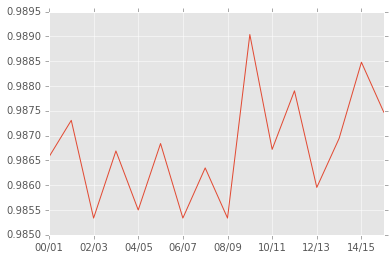

In [217]:
#clubCoefficients.apply(lambda list_of_values: len([x for x in list_of_values if x>0])).plot.line()
clubCoefficients.apply(gini).plot.line()

In [125]:
cl=getClubCoefficientsForSeason(2010)
co=getCountryCoefficientsForSeason(2010)

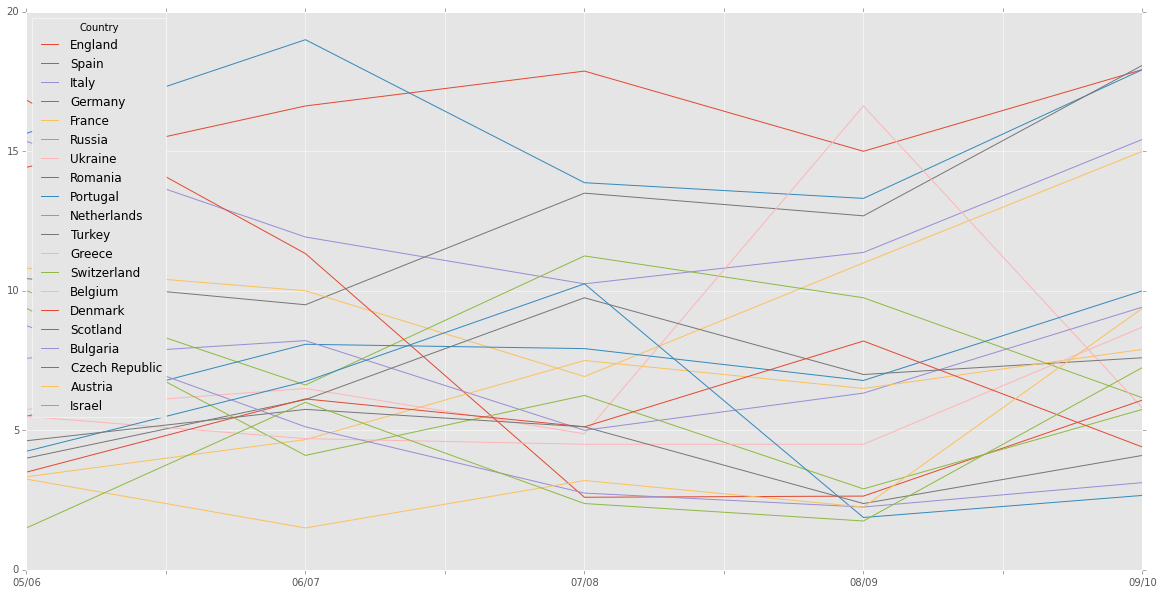

In [138]:
co.set_index('Country').ix[:20][co.columns[2:-2]].T.plot.line(figsize=(20,10))

In [109]:
ts1['calculatedPoints']=(ts1['wins']*3)+ts1['draws']
ts1['calculatedMatches']=ts1['wins']+ts1['draws']+ts1['losses']
ts1['calculatedGoalDiff']=ts1['goalsFor']-ts1['goalsAgainst']

ts1[['points','calculatedPoints','wins','draws','matches','calculatedMatches','goalDiff','calculatedGoalDiff']]

,points,calculatedPoints,wins,draws,matches,calculatedMatches,goalDiff,calculatedGoalDiff
0,79,79,25,4,30,30,59,59
1,66,66,19,9,30,30,43,43
2,50,50,14,8,30,30,16,16
3,48,48,14,6,30,30,-9,-9
4,46,46,13,7,30,30,16,16
5,40,40,11,7,30,30,3,3
6,38,38,10,8,30,30,-2,-2
7,37,37,10,7,30,30,-5,-5
8,37,37,10,7,30,30,-10,-10
9,35,35,8,11,30,30,-10,-10


In [227]:
def getPlayersByLeagueSeasonFile(league,season):
    filename = league + "_" + str(season)
    df = pd.read_excel("../data/rawindex/" + filename + ".xls",index_col=2,names=['','name'])
    df["filename"]=filename
    df["league"]=league
    df["season"]=season
    return df

players = pd.concat([getPlayersByLeagueSeasonFile(league,season) \
     for season in range(2001,2016) \
     for league in ['GB1','ES1','IT1','L1','FR1','TR1','RU1','PO1','NL1','BE1','GB2','MLS1']])[["name","filename","league"]] \
    .drop_duplicates(subset=['name','league']).sort_index()

#[DataFrame(players[players["filename"]==x])["name"] for x in players["filename"].drop_duplicates()]



,name,filename,league
7767,Fernando Torres,ES1_2002,ES1
7767,Fernando Torres,IT1_2014,IT1
7767,Fernando Torres,GB1_2007,GB1


In [302]:
def getPersonalFile(league,season):
    filename = league + "_" + str(season)
    result = pd.read_csv("../data/personal/" + filename + ".csv")
    result['filename'] = filename
    return result

df = pd.concat([getPersonalFile(league, season) for season in range(2001,2016) for league in ['GB1']])
df[pd.notnull(df['error'])][['id','error','filename']]

,id,error,filename
100,108471,'NoneType' object has no attribute 'find_all',GB1_2011
81,73786,'NoneType' object has no attribute 'find_all',GB1_2013


In [316]:
#getPlayerDataFromBs(getBsByPlayerId(73786))

#bs = getBsByPlayerId(45559)  TRANSIENT?
#bs = getBsByPlayerId(87658)  TRANSIENT?
#bs = getBsByPlayerId(108471)  ?????
#bs = getBsByPlayerId(145466 ) FIXED
#bs = getBsByPlayerId(73786) ?????
#bs = getBsByPlayerId(206225) FIXED

bs = getBsByPlayerId(196628) 

getPlayerDataFromBs(bs)

now processing Alessandro Stefanini


{u'Age': u'28',
 u'Contract until': u'-',
 'Country of birth': u'Italy',
 u'Current club': u'Rosignano Sei Rose',
 'Current club id': u'27543',
 u'Date of birth': u'Jun 23, 1987',
 'Display name': u'Alessandro Stefanini',
 u'In the team since': u'Jul 1, 2011',
 u'Place of birth': u'Firenze',
 u'Position': u'Midfield',
 'birthDate': u'Jun 23, 1987 (28)'}

In [303]:
def getTransfersFile(league,season):
    filename = league + "_" + str(season)
    result = pd.read_csv("../data/transfers/" + filename + ".csv")
    result['filename'] = filename
    return result

df = pd.concat([getTransfersFile(league, season) for season in range(2001,2016) for league in ['GB1']])
df[pd.notnull(df['error'])][['id','error','filename']]

,id,error,filename
5787,145527,'NoneType' object has no attribute 'find_all',GB1_2001
2728,63533,'NoneType' object has no attribute 'find_all',GB1_2002
2729,128831,'NoneType' object has no attribute 'find_all',GB1_2002
2163,14077,'NoneType' object has no attribute 'find_all',GB1_2004
627,45559,'NoneType' object has no attribute 'find',GB1_2008
226,87658,'NoneType' object has no attribute 'find',GB1_2009
1530,108471,'NoneType' object has no attribute 'find_all',GB1_2011
1571,325105,'NoneType' object has no attribute 'find_all',GB1_2013
1572,73786,'NoneType' object has no attribute 'find_all',GB1_2013
1275,296986,'NoneType' object has no attribute 'find_all',GB1_2014


In [306]:
bs = getBsByPlayerId(108471)  

getTransfersFromBs(bs)

AttributeError: 'NoneType' object has no attribute 'find_all'

In [299]:
df.drop('error',axis=1)

,date,fee,filename,fromCountry,fromTeamId,fromTeamName,id,mv,playerName,season,toCountry,toTeamId,toTeamName
0,"Jul 1, 2014",-,GB1_2001,Australia,970,Perth Glory,4096,300 Th. €,Jacob Burns,14/15,NaN,123,End of career
1,"Jul 1, 2009",Free transfer,GB1_2001,Romania,10442,Unirea Urziceni,4096,400 Th. €,Jacob Burns,09/10,Australia,970,Perth Glory
2,"Feb 1, 2008",Free transfer,GB1_2001,Poland,422,Wisla Kraków,4096,450 Th. €,Jacob Burns,07/08,Romania,10442,Unirea Urziceni
3,"Feb 1, 2006",100 Th. €,GB1_2001,England,349,Barnsley FC,4096,400 Th. €,Jacob Burns,05/06,Poland,422,Wisla Kraków
4,"Jan 1, 2004",-,GB1_2001,England,515,Unattached,4096,-,Jacob Burns,03/04,NaN,349,Barnsley FC
5,"Jul 1, 2003",-,GB1_2001,England,399,Leeds,4096,-,Jacob Burns,03/04,NaN,515,Unattached
6,"Jul 1, 2000",375 Th. €,GB1_2001,Australia,2500,Parra. Power,4096,-,Jacob Burns,00/01,England,399,Leeds
7,"Jul 1, 1999",?,GB1_2001,Australia,6045,Sydney United,4096,-,Jacob Burns,99/00,Australia,2500,Parra. Power
8,"Jan 11, 2016",-,GB1_2001,England,2804,Barnet,4097,150 Th. €,Kevin Lisbie,15/16,NaN,515,Unattached
9,"Jul 1, 2015",Free transfer,GB1_2001,England,1150,Leyton Orient,4097,150 Th. €,Kevin Lisbie,15/16,England,2804,Barnet


In [276]:
url = "https:// twitter.com/timream5"
url.split("//")[-1].split("/")[0].split(".")[-2]

' twitter'

In [146]:
bs = getBsByPlayerId(69651)

In [151]:
#getPlayerDataFromBs(bs)
DataFrame(getTransfersFromBs(bs))

,date,fee,fromCountry,fromTeamId,fromTeamName,mv,playerName,season,toCountry,toTeamId,toTeamName
0,"May 16, 2016",End of loan,Scotland,43,Heart of Midl.,700 Th. €,Abiola Dauda,15/16,Netherlands,499,Vitesse
1,"Feb 1, 2016",Loan,Netherlands,499,Vitesse,700 Th. €,Abiola Dauda,15/16,Scotland,43,Heart of Midl.
2,"Jul 24, 2014",500 Th. €,Serbia,159,Red Star,"1,25 Mill. €",Abiola Dauda,14/15,Netherlands,499,Vitesse
3,"Feb 8, 2013",Free transfer,Sweden,3654,Kalmar FF,"1,00 Mill. €",Abiola Dauda,12/13,Serbia,159,Red Star
4,"Jan 1, 2008",?,Sweden,8905,Sölvesborgs GoIF,-,Abiola Dauda,07/08,Sweden,3654,Kalmar FF


In [97]:
bs = BeautifulSoup(urlopen(Request(getUrlByPlayerId(7767), headers={'User-Agent': useragent})))

In [131]:
nationalTeamLinks=[a for a in bs.find(class_="dataContent").findAll("a") if '/nationalmannschaft/' in a.get("href")]

if nationalTeamLinks:
    print '/'.join([a.getText() for a in nationalTeamLinks])
    print nationalTeamLinks[0].get("href").split("/")[-1]

110/38
3375


In [175]:
index = pd.read_csv('../data/index/NL1_2015.csv', index_col=0,names=['name'])
index

,name
22372,Tom van Hyfte
37217,Pär Hansson
51969,Marcel Appiah
56379,Erik Quekel
57333,Jergé Hoefdraad
58342,Sheran Yeini
60289,Rajko Brezancic
64511,Jeroen Tesselaar
75219,Jasper Heusinkveld
78818,Dario Dumic


In [217]:
league='NL1'
season=2015
filename=league+'_'+str(season)
personalFile='../data/personal/'+filename+'.csv'
transfersFile='../data/transfers/'+filename+'.csv'
if os.path.isfile(personalFile) and os.path.isfile(transfersFile) \
    and (not 'error' in pd.read_csv(personalFile).columns) \
    and (not 'error' in pd.read_csv(transfersFile).columns):
    print str(datetime.datetime.now()), filename, "files already complete"
else:
    print str(datetime.datetime.now()), "retrieving", filename
    index = pd.read_csv('../data/index/'+league+'_'+str(season)+'.csv', index_col=0,names=['name'])
    dataList=[]
    transfersList=[]
    for id in [22372,51969,37217]:
        try:
            bs = getBsByPlayerId(id)
        except Exception as e:
            print "error", e
        try:
            data = getPlayerDataFromBs(bs)
            data.update({'id':id})
        except Exception as e:
            print "error", e
            data = {'id':id, 'error': e}
        dataList.append(data)
        try:
            transfers = getTransfersFromBs(bs)
            [transfer.update({'id':id}) for transfer in transfers]
        except Exception as e:
            transfers = [{'id':id, 'error': e}]
        transfersList.append(transfers)
DataFrame(dataList).to_csv(personalFile,index=False,encoding='utf-8')
pd.concat([DataFrame(transfers) for transfers in transfersList], ignore_index=True).to_csv(transfersFile,index=False,encoding='utf-8')
print str(datetime.datetime.now()), "done"   

2016-05-21 02:12:05.431244 NL1_2015 files already complete
2016-05-21 02:12:05.445932 done


In [222]:
df = pd.read_csv(transfersFile)
df.index= df['id']
df

,date,fee,fromCountry,fromTeamId,fromTeamName,id,mv,playerName,season,toCountry,toTeamId,toTeamName
id,,,,,,,,,,,,
22372,"Jul 1, 2014",Free transfer,Netherlands,384,MVV,22372,275 Th. €,Tom van Hyfte,14/15,Netherlands,192,Roda JC
22372,"Jul 1, 2009",Free transfer,Belgium,3134,KFC VW Hamme,22372,200 Th. €,Tom van Hyfte,09/10,Netherlands,384,MVV
22372,"Jul 1, 2004",75 Th. €,Belgium,3038,RSC Anderlecht U19,22372,-,Tom van Hyfte,04/05,Belgium,3134,KFC VW Hamme
37217,"Jan 25, 2016",Free transfer,Sweden,699,Helsingborgs IF,37217,"1,50 Mill. €",Pär Hansson,15/16,Netherlands,234,Feyenoord
37217,"Dec 1, 2008",End of loan,Sweden,3625,Ängelholm,37217,75 Th. €,Pär Hansson,08/09,Sweden,699,Helsingborgs IF
37217,"Feb 1, 2008",Loan,Sweden,699,Helsingborgs IF,37217,75 Th. €,Pär Hansson,07/08,Sweden,3625,Ängelholm
37217,"Dec 1, 2007",End of loan,Sweden,3625,Ängelholm,37217,75 Th. €,Pär Hansson,07/08,Sweden,699,Helsingborgs IF
37217,"Feb 1, 2006",Loan,Sweden,699,Helsingborgs IF,37217,75 Th. €,Pär Hansson,05/06,Sweden,3625,Ängelholm
37217,"Jan 1, 2006",-,Sweden,8659,Helsingborg U19,37217,-,Pär Hansson,05/06,Sweden,699,Helsingborgs IF


In [204]:
DataFrame(dataList)
#pd.concat([DataFrame(transfers) for transfers in transfersList], ignore_index=True)

,Age,Contract until,Country of birth,Current club,Current club id,Date of birth,Date of last contract extension,Detailed position,Display name,Foot,...,Name in home country,National team id,Nationality,Place of birth,Player's agent,Player's agent id,Position,birthDate,id,website
0,30,30.06.2018,Belgium,Roda JC Kerkrade,192,"Apr 28, 1986","Sep 4, 2015",Main position:Central Midfield Side position: ...,Tom van Hyfte,left,...,NaN,NaN,Belgium,Gent,Forza Sports Group,2553,Midfield - Central Midfield,"Apr 28, 1986 (30)",22372,NaN
1,29,30.06.2017,Sweden,Feyenoord Rotterdam,234,"Jun 22, 1986",NaN,Main position:Keeper,Pär Hansson,right,...,Pär Johan Åke Hansson,3557,Sweden,Vejbystrand,Global Soccer Management,786,Goalkeeper,"Jun 22, 1986 (29)",37217,NaN
2,28,30.06.2016,Germany,NEC Nijmegen,467,"Mar 26, 1988","Jun 26, 2015",Main position:Right-Back Side position: Centre...,Marcel Appiah,right,...,NaN,NaN,Germany Ghana,Schwelm,neblung sportsnetwork,175,Defence - Right-Back,"Mar 26, 1988 (28)",51969,NaN
3,29,30.06.2017,Netherlands,De Graafschap Doetinchem,642,"Apr 16, 1987",NaN,Main position:Centre Forward Side position: Ri...,Erik Quekel,NaN,...,NaN,NaN,Netherlands,Den Bosch,NaN,NaN,Striker - Centre Forward,"Apr 16, 1987 (29)",56379,NaN
4,29,30.06.2016,Netherlands,SC Cambuur-Leeuwarden,133,"Jul 17, 1986",NaN,Main position:Left Wing Side position: Attacki...,Jergé Hoefdraad,left,...,NaN,NaN,Netherlands Suriname,Amsterdam,NaN,NaN,Striker - Left Wing,"Jul 17, 1986 (29)",57333,https://www.jergehoefdraad.nl
5,29,30.06.2019,Israel,Vitesse Arnhem,499,"Dec 8, 1986",NaN,Main position:Defensive Midfield Side position...,Sheran Yeini,right,...,שרן ייני‎,5547,Israel,Tel Aviv,Top Sport Services,231,Midfield - Defensive Midfield,"Dec 8, 1986 (29)",58342,NaN
6,26,30.06.2018,Jugoslawien (SFR),AZ Alkmaar,1090,"Aug 21, 1989",NaN,Main position:Left-Back Side position: Left Wing,Rajko Brezancic,left,...,Рајко Брежанчић,9566,Serbia Bosnia-Herzegovina,Vlasenica,GET11 AG,2208,Defence - Left-Back,"Aug 21, 1989 (26)",60289,NaN


In [ ]:
new BeautifulSoup()

In [56]:
for season in range(2015,2016):
    for league in ['GB1']:
        filename = league + "_" + str(season) + ".xls"
        if os.path.isfile(filename):
            print str(datetime.datetime.now()), filename, "already exists"
        else:
            print str(datetime.datetime.now()), "retrieving", filename
            DataFrame([player for club in getClubsByLeagueId(league,season) \
                                             for player in getPlayersByClubId(club['clubId'],season)]).to_excel(filename)
            print str(datetime.datetime.now()), "done"

GB1_2015.xls already exists


In [69]:
str(datetime.datetime.now())

'2016-05-19 23:30:41.259962'

In [ ]:
#epl = [getPlayerData(player["playerId"]) for club in getClubsByLeagueId('GB1') for player in getPlayersByClubId(club["clubId"])]
bundesliga = [getPlayerData(player["playerId"]) for club in getClubsByLeagueId('L1')[:2] for player in getPlayersByClubId(club["clubId"])]
DataFrame(bundesliga).to_excel("bundesliga.xls")

In [22]:
clubs=[]
for league in youthLeagues+tier1+tier2+tier3:
    result=getClubsByLeagueId(league)
    [club.update({'league': league}) for club in result]
    clubs.extend(result)

In [21]:
clubs

In [23]:
DataFrame(clubs)

,clubId,league,name
0,9249,GB21,Arsenal FC U21
1,9252,GB21,Liverpool FC U21
2,9261,GB21,Everton FC U21
3,39341,GB21,Leicester City U21
4,39336,GB21,Brighton & Hove Albion U21
5,33616,GB21,Swansea City U21
6,9265,GB21,Manchester City U21
7,9267,GB21,West Ham United U21
8,9250,GB21,Chelsea FC U21
9,24226,GB21,Wolverhampton Wanderers U21


In [12]:
a = [1,2,3]
a.extend([4,5,6])
a

[1, 2, 3, 4, 5, 6]

In [ ]:
DataFrame(getTransfersByPlayerId(121483))

In [ ]:
DataFrame(getClubsByLeagueId('GB1',2010))  #.sort_values(by="clubId")

In [ ]:
DataFrame(getPlayersByClubId(418,2005))